In [311]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import multiprocessing
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", level=logging.INFO)

cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print(cores)
# np.random.seed(42)

12


# Implementing the DeepWalk paradigm
## Algorithm
- We are given an adjacency matrix -> this acts as a set of rules (vocabulary)
- We are going to generate linear chains to be able to predict the context/neighborhood of a given node
- So, using the adjacency matrix, we generate many random walks of a fixed length.
- The random walks will become our dataset to feed and train the `SkipGram` model.

In [312]:
class DeepWalk():
        def __init__(
                        self, 
                        graph : "list[list[int]]", 
                        window_size : int, 
                        embedding_size : int, 
                        walks_per_vertex : int, 
                        walk_length : int
                ) -> None:
                """
                Initialize the DeepWalk model. This directly from the paper https://arxiv.org/pdf/1403.6652.pdf.

                Parameters
                ----------
                graph : list[list[int]]
                        The adjacency list to be embedded. This is a list of lists, where each list is a vertex and its neighbors.
                window_size : int
                        The window size for the skipgram model.
                embedding_size : int
                        The size of the embedding. The final output matrix will be of size |V| x embedding_size.
                walks_per_vertex : int
                        The number of walks to perform per vertex.
                walk_length : int
                        The length of each walk.

                Methods
                -------
                generate_n_walks()
                        Generate n walks from the graph.
                train()
                        Train the model.
                update()
                        Feed model new walks.
                get_embeddings()
                        Return the embeddings.
                """

                # DeepWalk parameters
                self.g = graph
                self.w = window_size
                self.d = embedding_size
                self.gamma = walks_per_vertex
                self.epochs = self.gamma
                self.t = walk_length
                self.n = len(graph)

        def unbiased_random_walk(
                self,
                adj_mat : 'list[list[int]]', 
                walk_len : 'int', 
                start_node : 'int'
        ) -> np.array:
                """
                Returns a random walk of length walk_len from start_node in the graph.

                Parameters
                ----------
                adj_mat : list[list[int]]
                        Adjacency matrix of the graph.
                walk_len : int
                        Length of the random walk.
                start_node : int
                        Starting node of the random walk.

                Returns
                -------
                np.array
                        List of nodes in the random walk.        
                """
                # Array to store the walk
                walk = [start_node]

                # Make an adjacency matrix to easily 
                # sample the neighbors of a node.
                adj_list = []
                for i in range(len(adj_mat)):
                        # This line was autocompleted by GH Copilot
                        adj_list.append(np.where(adj_mat[i] > 0)[0])

                # Keep walking for walk_len epochs
                for epochs in range(walk_len):
                        # Randomly pick a node from the adj_list[walk[-1]] 
                        # and append it to the walk
                        walk.append(np.random.choice(adj_list[walk[-1]]))

                return np.array(walk)

        def generate_n_walks(self, num_iters : int) -> 'list[list[str]]':
                """
                Generate a list of num_iters random walks. These will be used to train the model

                Parameters
                ----------
                num_iters : int
                        Number of walks to generate.

                Returns
                -------
                np.ndarray
                        List of random walks.
                """

                # List to store the walks
                walks = []

                # For each vertex in the graph
                for vertex in range(self.n):
                        # Generate gamma walks of length t
                        for _ in range(self.gamma):
                                walks.append(self.unbiased_random_walk(self.g, self.t, vertex))

                walks = [[str(node) for node in walk] for walk in walks]

                return walks

        def train(self, epochs : int, lr : float) -> None:
                """
                Train the model.

                Parameters
                ----------
                epochs : int
                        Number of epochs to train the model for.
                lr : float
                        Learning rate for the optimizer.                
                """

                # Generate many walks
                walks = self.generate_n_walks(self.gamma)

                # Initialize the model
                self.model = Word2Vec(
                        walks,
                        hs=1,
                        sg=1,
                        negative=0,
                        alpha=0.05,
                        epochs=epochs, 
                        vector_size=self.d,        # embedding dimension
                        window=self.w,             # context window size
                        min_count=0,
                        workers=cores-2
                )

        def get_embeddings(self) -> np.ndarray:
                """
                Return the embeddings.

                Returns
                -------
                np.ndarray
                        Embeddings.
                """
                return [self.model.wv[str(n)] for n in range(self.n)]
        
        def plot_embeddings(self, num_dimensions : int, gt_labels : 'list[str]') -> None:
                """
                Plot the embeddings.

                Parameters
                ----------
                num_dimensions : int
                        Number of dimensions to plot.
                gt_labels : list[str]
                        List of ground truth labels.
                """
                embeddings = np.array(self.get_embeddings())

                # Dimensionality reduction to 2 dimensions using t-SNE for visualization
                embeddings = TSNE(n_components=2).fit_transform(embeddings)

                # Convert gt into numbers
                gt_labels = np.array(gt_labels)

                # Iterate over all labels and assign them an integer
                for i, label in enumerate(np.unique(gt_labels)):
                        gt_labels[gt_labels == label] = i
                gt_labels = gt_labels.astype(int)

                # plot the embeddings
                plt.figure(figsize=(10, 8))
                # plt.scatter(embeddings[:,0], embeddings[:,1], c=gt_labels)
                plt.scatter(embeddings[:, 0], embeddings[:, 1], c=gt_labels, cmap='plasma', edgecolors='w', s=150, alpha=1.0)

                # Set plot title and axis labels
                plt.title(f"2D Embedding Visualization using t-SNE with {num_dimensions} components")
                plt.xlabel("Dimension 1")
                plt.ylabel("Dimension 2")

                # Plot node numbers
                offset = 2.  # Adjust the offset value as needed
                for i, (x, y) in enumerate(embeddings):
                        plt.text(x + offset, y + offset, str(i), fontsize=12, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.0))
                        
                plt.show()

## Veryfying with groud truth labels of clubs

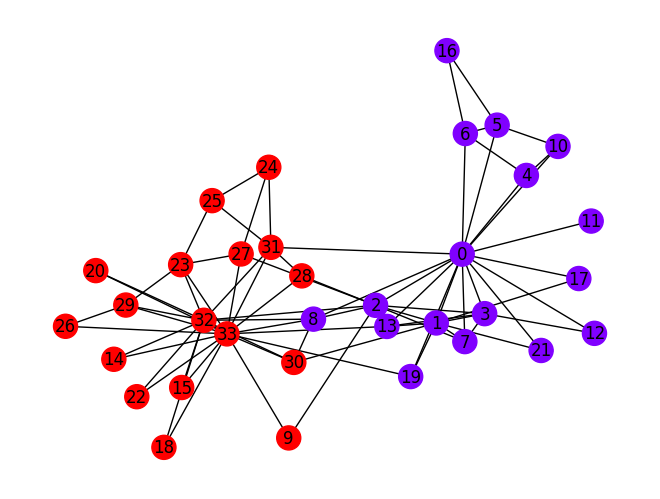

In [313]:
G = nx.karate_club_graph()
gt = []
for node in G.nodes():
    gt.append(G.nodes[node]['club'])

# Convert gt into numbers
gt_labels = np.array(gt)

# Iterate over all labels and assign them an integer
for i, label in enumerate(np.unique(gt_labels)):
        gt_labels[gt_labels == label] = i
gt_labels = gt_labels.astype(int)

nx.draw(G, with_labels=True, node_color=gt_labels, cmap=plt.cm.rainbow)
adjmat = nx.adjacency_matrix(G).todense()

In [314]:
# adjmat, window_size, embedding_size, walks_per_vertex, walk_length
dw = DeepWalk(adjmat, 10, 128, 10, 80)

In [315]:
dw.train(20, 0.05)

INFO - 2023-11-27 12:34:21,407: collecting all words and their counts
INFO - 2023-11-27 12:34:21,408: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 2023-11-27 12:34:21,411: collected 34 word types from a corpus of 27540 raw words and 340 sentences
INFO - 2023-11-27 12:34:21,412: Creating a fresh vocabulary
INFO - 2023-11-27 12:34:21,413: Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 34 unique words (100.00% of original 34, drops 0)', 'datetime': '2023-11-27T12:34:21.413364', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'platform': 'Linux-5.15.133.1-microsoft-standard-WSL2-x86_64-with-glibc2.29', 'event': 'prepare_vocab'}
INFO - 2023-11-27 12:34:21,413: Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 27540 word corpus (100.00% of original 27540, drops 0)', 'datetime': '2023-11-27T12:34:21.413911', 'gensim': '4.3.2', 'python': '3.8.10 (default, May 26 2023, 14:05:08) \n[GCC 9.4.0]', 'plat

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


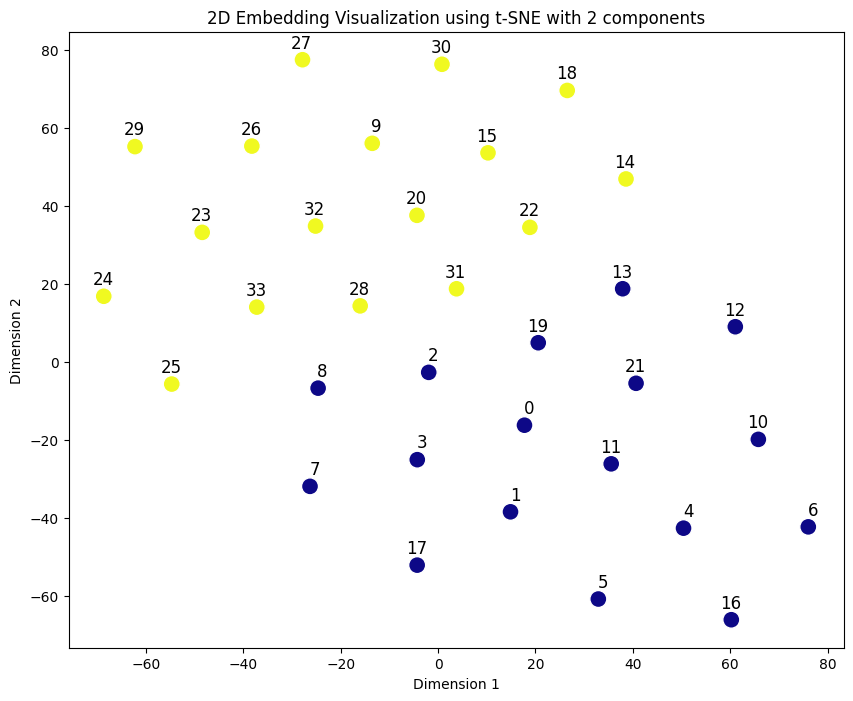

In [316]:
dw.plot_embeddings(2, gt)

In [317]:
embeddings_save = dw.get_embeddings()

## Verifying with Modularity-based Clustering

In [318]:
# getting the embeddings from the model
embeddings = np.array(dw.get_embeddings())

In [319]:
from sknetwork.clustering import Louvain, get_modularity
import scipy.sparse as sp
from sknetwork.visualization import svg_graph, svg_bigraph

In [320]:
louvain = Louvain()
labels = louvain.fit_predict(adjmat)

In [321]:
print(labels)

[1 1 1 1 3 3 3 1 0 0 3 1 1 1 0 0 3 1 0 1 0 1 0 2 2 2 0 2 2 0 0 2 0 0]


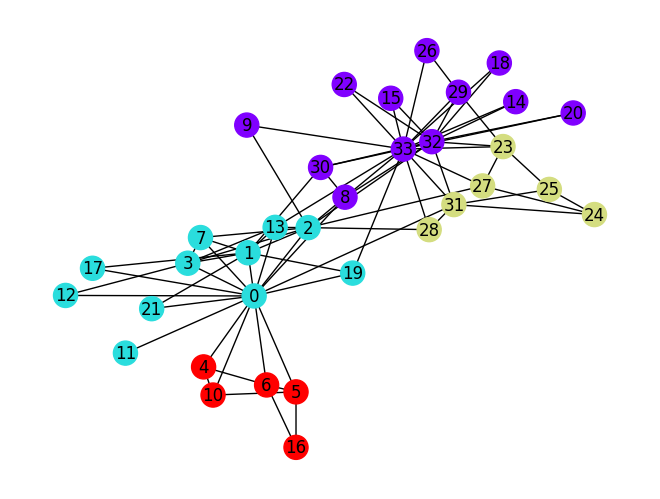

In [322]:
G = nx.karate_club_graph()
nx.draw(G, with_labels=True, node_color=labels, cmap=plt.cm.rainbow)
adjmat = nx.adjacency_matrix(G).todense()

In [323]:
embeddings_save = embeddings

/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ujjwal-shake-her/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


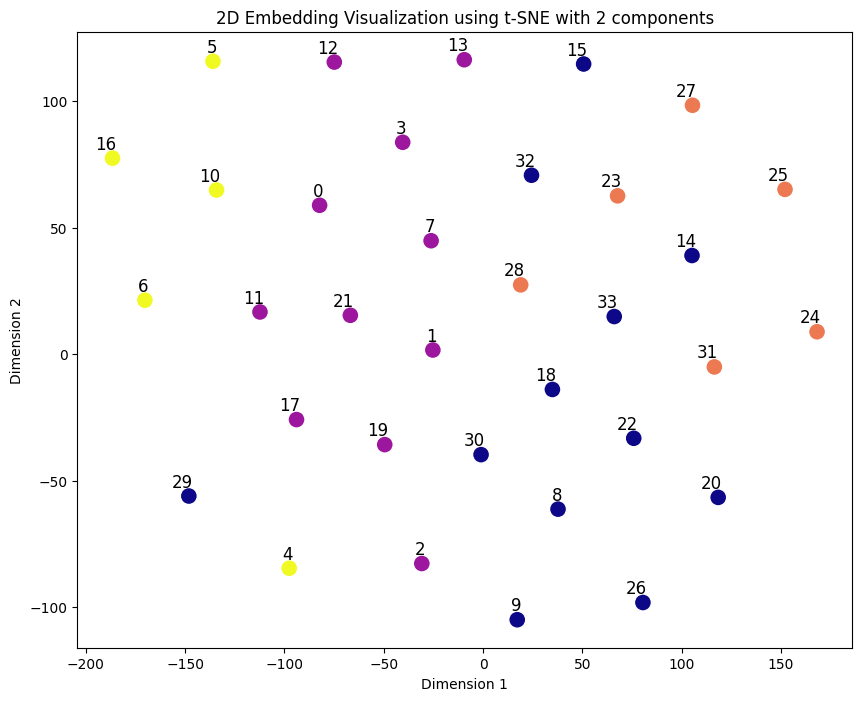

In [324]:
dw.plot_embeddings(2, labels)